In [0]:
from keras.models import Model, Sequential, model_from_json
from keras.layers import Input, Dense, Flatten, Dropout, LSTM
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from keras.layers.merge import concatenate
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
import matplotlib.pylab as plt
from random import seed
from math import sqrt
import pandas as pd
import numpy as np
from numpy import hstack, array

In [0]:
def plotClosePriceByDate(dataset):
  # setting date as our data index
  dataset['Date'] = pd.to_datetime(dataset.Date, format = '%Y-%m-%d')
  dataset.index = dataset['Date']

  # plot close price history
  plt.figure(figsize = (16, 8))
  plt.plot(dataset['Close'])
  plt.xlabel("Date")
  plt.ylabel("Close Price")
  plt.title("Close Price history")
  plt.legend()
  plt.show()

In [0]:
def setInitalParameters(number_of_steps, number_of_features):
  # choose a number of time steps
  n_steps = number_of_steps
  
  # choose a number of features
  n_features = number_of_features
  
  return n_steps, n_features

In [0]:
def getDatasetModified(df):
  open = df['Open'].as_matrix()
  high = df['High'].as_matrix()
  low = df['Low'].as_matrix()
  close = df['Close'].as_matrix()
  adj_close = df['Adj Close'].as_matrix()
  volume = df['Volume'].as_matrix()


  open_h = open.reshape((len(open), 1))
  high_h = high.reshape((len(high), 1))
  low_h = low.reshape((len(low), 1))
  close_h = close.reshape((len(close), 1))
  adj_close_h = adj_close.reshape((len(adj_close), 1))
  volume_h = volume.reshape((len(volume), 1))
  
  dataset = hstack((open_h, high_h, low_h, adj_close_h, volume_h, close_h))
  return dataset

In [0]:
# split a multivariate sequence into samples
def split_sequences_multi(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset 
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [0]:
def getTrainTest(data, number_of_steps, size_of_test):
  # split into samples
  X, Y = split_sequences_multi(data, number_of_steps)

  # let's split X and Y data into test and train datasets, test data is size_of_test * 100% of overall data
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = size_of_test, random_state = 42)
  
  return x_train, x_test, y_train, y_test

In [0]:
def plotGraph(actual, predicted):
  plt.figure(figsize=(20, 10))
  plt.plot(actual)
  plt.plot(predicted)
  plt.title('Actual vs Predicted')
  plt.legend(['Actual', 'Predicted'], loc='best')
  plt.show()

In [0]:
def getLoadedModel(modelName):
  # load json and create model
  json_file = open(str(modelName) + '.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # load weights into new model
  loaded_model.load_weights(str(modelName) + ".h5")
  print("Loaded model from disk")
  return loaded_model

In [0]:
def saveModel(model, modelName):
  # serialize model to JSON
  model_json = model.to_json()
  with open(modelName + ".json", "w") as json_file:
    json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights(modelName + ".h5")
  print("Saved model to disk")

In [0]:
def printRMSE(y_test, y_pred):
  rmse = sqrt(mean_squared_error(y_test, y_pred))
  print('RMSE = ' + str(rmse))

In [0]:
def defineFitModel(number_of_steps, number_of_features, size, x_train_reshaped, y_train):
  # define model
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=size, activation='relu', input_shape=(number_of_steps, number_of_features)))
  model.add(MaxPooling1D(pool_size=size))
  model.add(Flatten())
  model.add(Dense(50, activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  # fit model
  model.fit(x_train_reshaped, y_train, epochs=1000, verbose=0)
  return model

In [0]:
def lstmModel(x_train, y_train):
  # create and fit the LSTM
  model = Sequential()
  model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
  model.add(LSTM(units = 50))
  model.add(Dense(1))
  model.compile(loss = 'mean_squared_error', optimizer = 'adam')
  model.fit(x_train, y_train, epochs = 1, batch_size = 1, verbose = 2)

  return model

In [0]:
# import all needed packages
importPackages()

# read data
df = pd.read_csv('AAPL.csv')

In [29]:
# print data head
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-05-11,18.195715,18.708570,18.160000,18.510000,12.295175,101164700
1,2009-05-12,18.508572,18.530001,17.607143,17.774286,11.806481,152370400
2,2009-05-13,17.601429,17.717142,17.054285,17.070000,11.338662,148992900
3,2009-05-14,17.111429,17.647142,17.100000,17.564285,11.666988,111956600
4,2009-05-15,17.474285,17.802856,17.372858,17.488571,11.616698,91891800


In [30]:
# print data tail
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2513,2019-05-06,204.289993,208.839996,203.500000,208.479996,207.680222,32443100
2514,2019-05-07,205.880005,207.419998,200.830002,202.860001,202.081787,38763700
2515,2019-05-08,201.899994,205.339996,201.750000,202.899994,202.121628,26339500
2516,2019-05-09,200.399994,201.679993,196.660004,200.720001,199.949997,34908600
2517,2019-05-10,197.419998,198.850006,192.770004,197.179993,197.179993,41183400


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


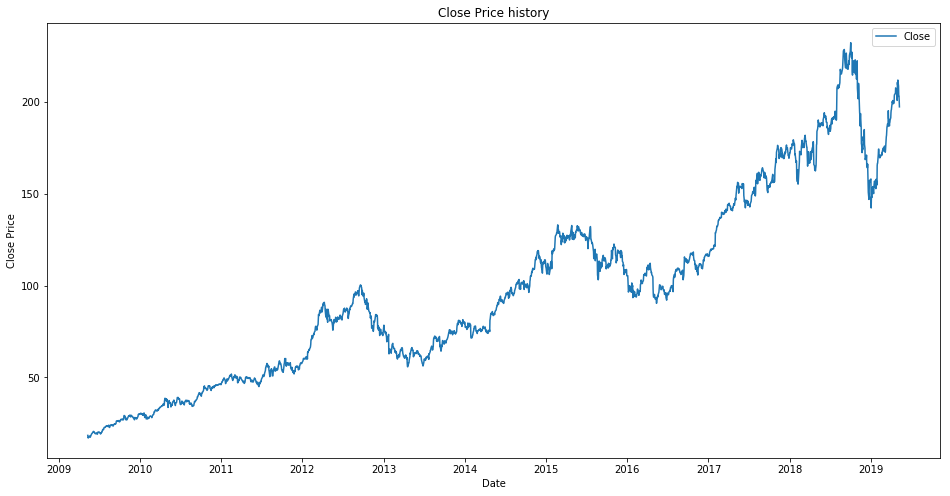

In [31]:
# plot close price by date
plotClosePriceByDate(df)

<h1> LSTM </h1>

Loaded model from disk
RMSE: 5.204993154659221


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


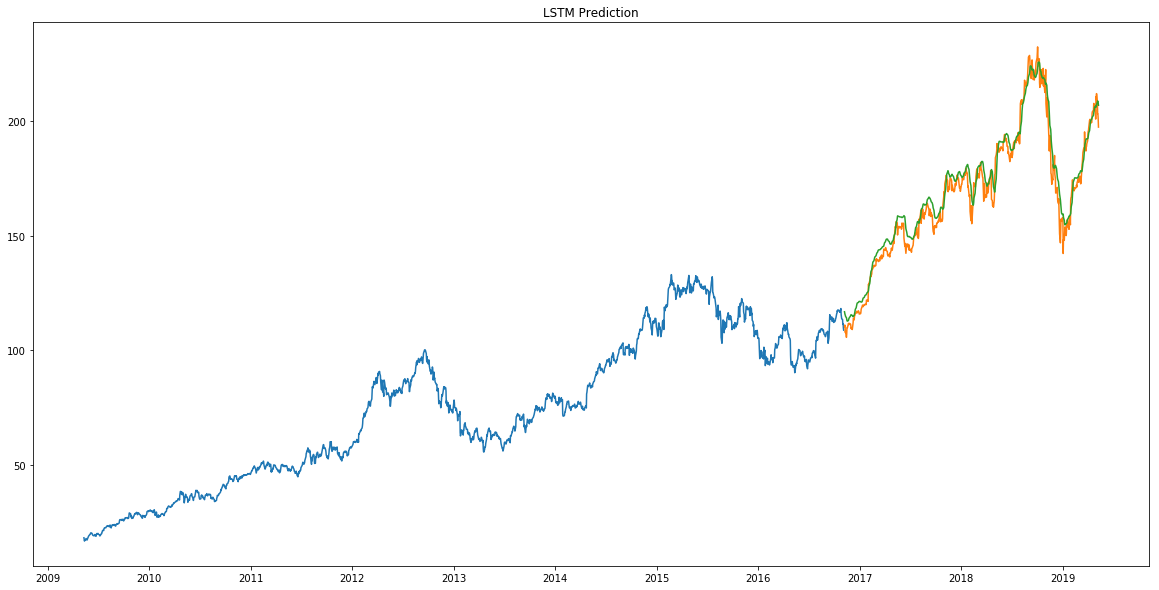

In [34]:
data_length = len(df)
new_data = pd.DataFrame(index = range(0, data_length), columns = ['Date', 'Close'])
for i in range(0, data_length):
    new_data['Date'][i] = df['Date'][i]
    new_data['Close'][i] = df['Close'][i]

# setting index
new_data.index = new_data.Date
new_data.drop('Date', axis = 1, inplace = True)

# creating train and test sets
data = new_data.values

# dividing dataset into train and test ones
index = data_length * 3//4
train = data[0:index,:]
test = data[index:,:]


######## I am going to use already saved model
######## if you want to ceate and fit the model open the commented part
# #converting dataset into x_train and y_train
# scaler = MinMaxScaler(feature_range = (0, 1))
# scaled_data = scaler.fit_transform(data)
# x_train, y_train = [], []
# for i in range(60, len(train)):
#     x_train.append(scaled_data[i-60:i,0])
#     y_train.append(scaled_data[i,0])
# x_train, y_train = array(x_train), array(y_train)
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# model0 = lstmModel(x_train, y_train)
# saveModel(model0, 'model0')

model0 = getLoadedModel('model0')

# predicting 1/4 of dataset values, using past 60 from the train data
inputs = new_data[data_length - len(test) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])
X_test = array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
closing_price = model0.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)


# rmse
rmse = np.sqrt(np.mean(np.power((test - closing_price), 2)))
print("RMSE:", rmse)

# plot the actual vs predicted
train = new_data[:index]
test = new_data[index:]
test['Predictions'] = closing_price
plt.figure(figsize=(20, 10))
plt.plot(train['Close'])
plt.plot(test[['Close','Predictions']])
plt.title("LSTM Prediction")
plt.show()

<h1> Multi-dimensional CNN (single-step using one value) </h1>


In [0]:
# get the dataset modified
dataset = getDatasetModified(df)

# some initial preparation
n_steps, n_features = setInitalParameters(1, 5)
x_train, x_test, y_train, y_test = getTrainTest(dataset, n_steps, 0.25)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_m

In [77]:
######## I am going to use already saved model
######## if you want to ceate and fit the model open the commented part
# define model
# model1 = defineFitModel(n_steps, n_features, 1, x_train, y_train)
# saveModel(model1, 'model1')

# get loaded model
loaded_model1 = getLoadedModel('model1')

Loaded model from disk


In [0]:
# reshaping the data
pred_1_1 = loaded_model1.predict(x_test)

# flatten the result
pred_flattened_1_1 = pred_1_1.flatten()

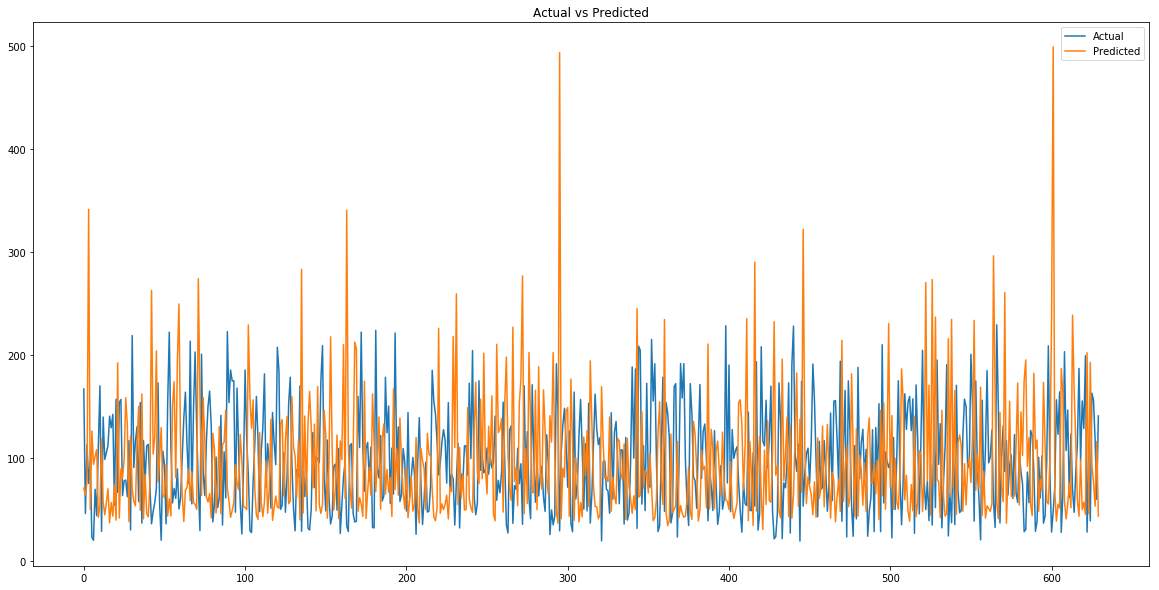

In [0]:
# plot the graph of predicted and actual values
plotGraph(y_test, pred_flattened_1_1)

In [0]:
printRMSE(y_test, pred_flattened_1_1)

RMSE = 97.89326489744205


<h1> Multi-dimensional CNN (single step using multiple values) </h1>

In [0]:
# some initial preparation
n_steps, n_features = setInitalParameters(2, 5)
x_train, x_test, y_train, y_test = getTrainTest(dataset, n_steps, 0.25)

In [47]:
######## I am going to use already saved model
######## if you want to ceate and fit the model open the commented part
# define model
# model2 = defineFitModel(n_steps, n_features, 1, x_train, y_train)
# saveModel(model2, 'model2')

# get loaded model
loaded_model2 = getLoadedModel('model2')

Loaded model from disk


In [0]:
# reshaping the data
pred_2_1 = loaded_model2.predict(x_test)

# flatten the result
pred_flattened_2_1 = pred_2_1.flatten()

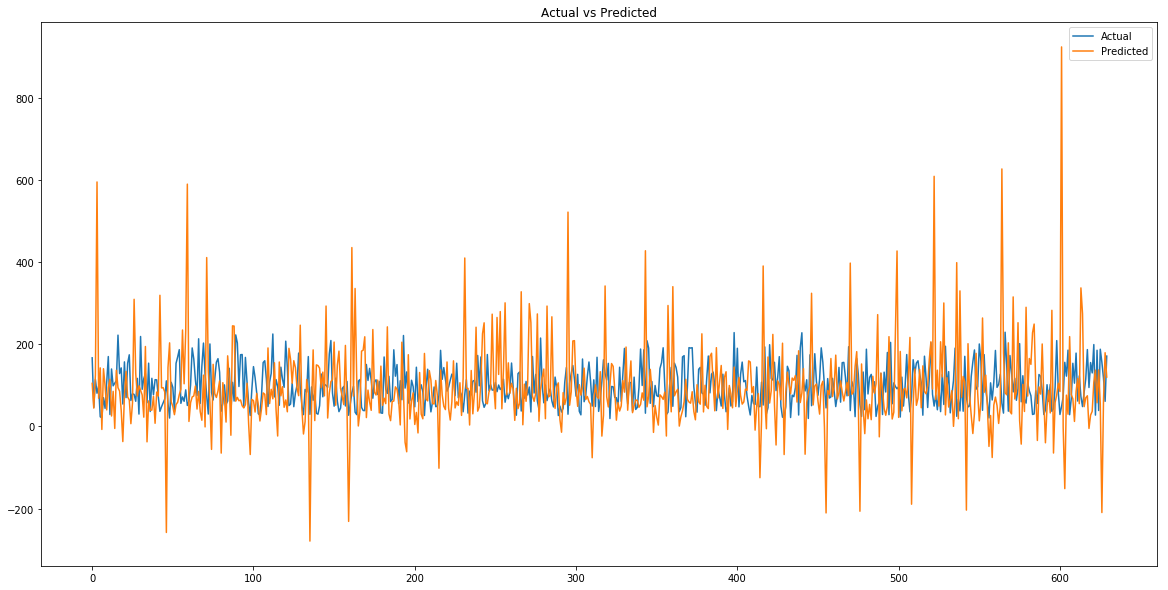

In [49]:
# plot the graph of presicted and actual values
plotGraph(y_test, pred_flattened_2_1)

In [50]:
printRMSE(y_test, pred_flattened_2_1)

RMSE = 124.96156894422413
